<a href="https://colab.research.google.com/github/vaibhav200-4/Imange_Enhancement-/blob/main/ImageEnhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow gradio numpy matplotlib


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
import os


In [ ]:
# Download dataset (train subset for demo)
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip -q DIV2K_train_HR.zip


--2025-07-03 02:56:29--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-07-03 02:56:30--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  19.4MB/s    in 2m 47s  

2025-07-03 02:59:17 (20.2 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [ ]:
def load_images(folder_path, img_size=(128, 128), limit=200):
    images_hr = []
    images_lr = []

    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = Image.open(os.path.join(folder_path, filename)).convert("RGB")
            img = img.resize(img_size)
            img_hr = np.array(img) / 255.0
            images_hr.append(img_hr)

            # Create low-res by resizing down & back up (simulate degradation)
            img_lr = img.resize((img_size[0]//2, img_size[1]//2))
            img_lr = img_lr.resize(img_size)
            images_lr.append(np.array(img_lr) / 255.0)

        if i >= limit-1:
            break

    return np.array(images_lr), np.array(images_hr)

# Load 200 image pairs for demo
x_train_lr, x_train_hr = load_images("DIV2K_train_HR", img_size=(128, 128), limit=200)

print("Low-res shape:", x_train_lr.shape)
print("High-res shape:", x_train_hr.shape)


Low-res shape: (200, 128, 128, 3)
High-res shape: (200, 128, 128, 3)


In [ ]:
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    x_train_lr, x_train_hr,
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_split=0.1
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.0706 - val_loss: 0.0550
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 912ms/step - loss: 0.0351 - val_loss: 0.0220
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 897ms/step - loss: 0.0175 - val_loss: 0.0154
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 857ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 898ms/step - loss: 0.0124 - val_loss: 0.0141
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 758ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 798ms/step - loss: 0.0105 - val_loss: 0.0111
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 798ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 741ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 811ms/step - loss: 0.0082 - val_loss: 0.0100
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 734ms/step - loss: 0.0086 - val_loss: 0.0095
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


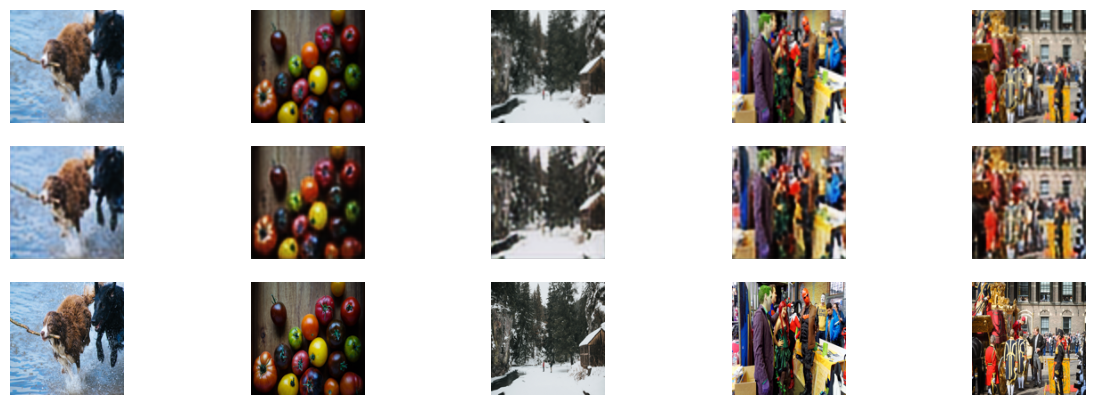

In [ ]:
decoded_imgs = autoencoder.predict(x_train_lr[:5])

n = 5
plt.figure(figsize=(15,5))
for i in range(n):
    # Low-res
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_train_lr[i])
    ax.axis('off')

    # Enhanced
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    ax.axis('off')

    # Original
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(x_train_hr[i])
    ax.axis('off')
plt.show()


In [ ]:
autoencoder.save("div2k_image_enhancer.keras")



# New Section

In [ ]:
# Load model
model = tf.keras.models.load_model("div2k_image_enhancer.keras")

# Define enhancement function
def enhance_image(input_img):
    img = Image.fromarray(input_img.astype('uint8')).resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    enhanced_img = model.predict(img_array)
    enhanced_img = np.clip(enhanced_img[0], 0, 1)
    return (enhanced_img * 255).astype('uint8')

# Gradio Interface
interface = gr.Interface(
    fn=enhance_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="DIV2K Image Enhancer CNN"
)

interface.launch(debug=True)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b6545d9b4dc19cdf3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b6545d9b4dc19cdf3e.gradio.live
